<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC3
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Recurrent Neural Networks

En esta práctica implementaremos redes neuronales recurrentes para generar música.

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

# 0. Contexto y referencias

Esta PEC está basada en el siguiente [artículo de investigación](https://arxiv.org/pdf/1711.07682.pdf), aunque por motivos de extensión no podremos pasar por todos los puntos del artículo.

La primera etapa de esta PEC será leer y entender la idea general de este trabajo. El artículo os da acceso al código original con el que se ha llevado a cabo el trabajo y en el que además esta basado gran parte del código que aquí os adjuntamos, aunque por la complejidad y extensión del código no os recomendamos que sumergáis demasiado en él.

La PEC consta de una etapa de ***interpretación de los datos*** (un paso vital en todo proyecto real), donde se pedirá reproducir una gráfica del artículo. Luego ***entrenaremos*** una red LSTM para generar acordes a partir de archivos MIDI. Finalmente, usaremos la capa de ***embedding*** de la red entrenada para hacer una proyección de los acordes en 2D y visualizar el concepto de [word2vec](https://en.wikipedia.org/wiki/Word2vec).

Además de este fichero os hemos adjuntado un archivo comprimido con una estructura de datos similar a la usada en el artículo y que os recomendamos (por vuestro bien) que no modifiquéis :). Allí encontraréis una carpeta llamada *data* donde se encuentra la base de datos que usaremos y otros ficheros que os facilitamos con datos de redes ya entrenadas (en la carpeta *models*)

# Sección 1. Análisis Exploratorio de los datos [1.5 pts]

## 1.1 Importación de módulos y paquetes necesarios

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# añade el path a tu directorio
%cd /content/drive/My Drive/deep_learning/PRA/dataset/practica_DL_UOC_2022

/content/drive/My Drive/deep_learning/PRA/dataset/practica_DL_UOC_2022


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
from collections import Counter
import collections
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


## 1.2 Carga de imágenes en dataset

In [4]:
import cv2

In [5]:
from inspect import classify_class_attrs
ROOT_PATH = '/content/drive/My Drive/deep_learning/PRA/dataset/practica_DL_UOC_2022'

def load_data(path: str):
  """
  """
  data = []
  for folder in os.listdir(path):
    print('Processing folder:' + folder)
    data.append(load_models(folder))
  return data

def load_models(folder):
  train = []
  test = []
  valid = []
  train = load_images(folder, 'train')
  test = load_images(folder, 'test')
  valid = load_images(folder, 'valid')

  return np.asarray(train, dtype=object), np.asarray(test, dtype=object), np.asarray(valid, dtype=object)

def load_images(folder, model):
  data = []
  path = os.path.join(folder, model)
  for classifier in os.listdir(path):
    print('Processing class:' + classifier)
    path = os.path.join(folder, model, classifier)
    for img in os.listdir(path):
      #print('Processing image:' + img)
      img_absolute_path = os.path.join(path, img)
      image_data_temp = cv2.imread(img_absolute_path)
      data.append([image_data_temp, classifier])
  return data


train, test, valid = load_models('Fold0')

Processing class:normal
Processing class:abnormal
Processing class:normal
Processing class:abnormal
Processing class:abnormal
Processing class:normal


In [6]:
train.shape, test.shape, valid.shape 

((1379, 2), (174, 2), (154, 2))

In [7]:
train[0][0].shape, test[0][0].shape, valid[0][0].shape 

((224, 224, 3), (224, 224, 3), (224, 224, 3))

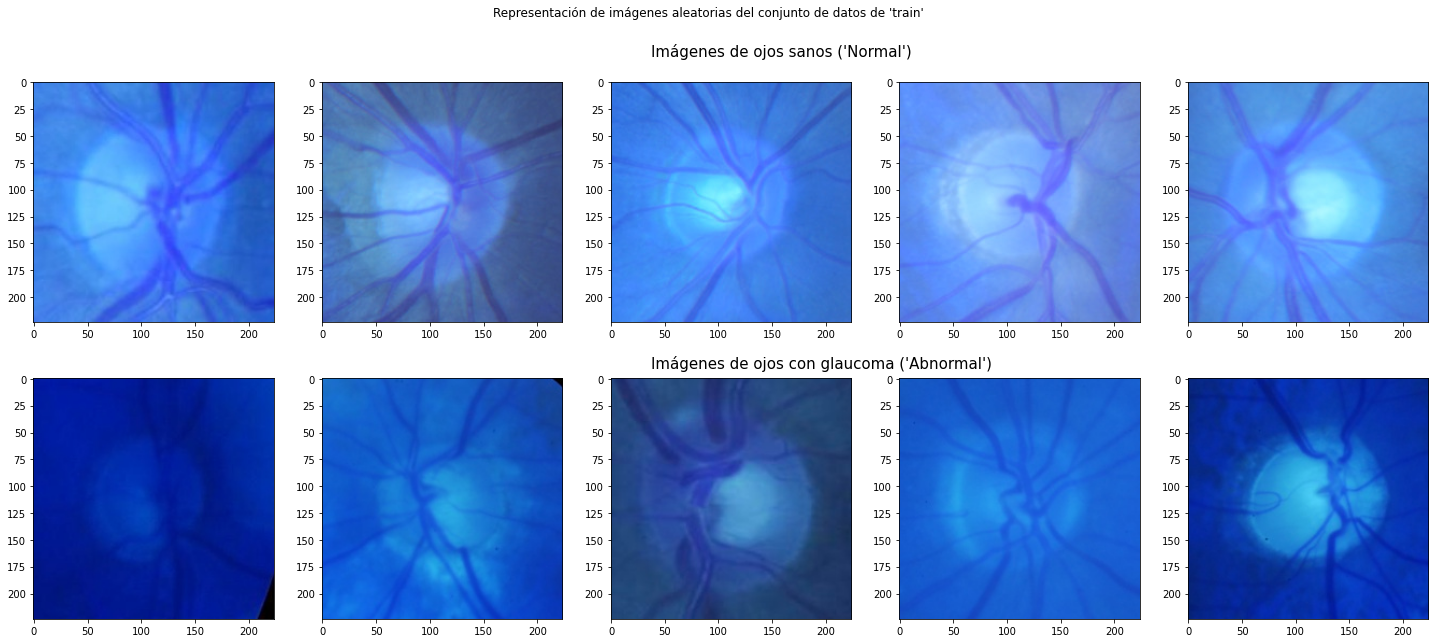

In [8]:
# Adjust proper figsize for scaling up the images
f, big_axes = plt.subplots(2,5, figsize=(25,10))

normal = train[np.where(train[:, 1] == 'normal')]
n = 0
for j in range(0,5):
  big_axes[0,j].imshow(normal[n][0])
  n = n + 1

abnormal = train[np.where(train[:, 1] == 'abnormal')]
n = 0
for j in range(0,5):
  big_axes[1,j].imshow(abnormal[n][0])
  n = n + 1

plt.text(-500, -300, 'Imágenes de ojos sanos (\'Normal\')', fontsize=15)
plt.text(-500, -10, 'Imágenes de ojos con glaucoma (\'Abnormal\')', fontsize=15)
plt.suptitle('Representación de imágenes aleatorias del conjunto de datos de \'train\'')

plt.show()


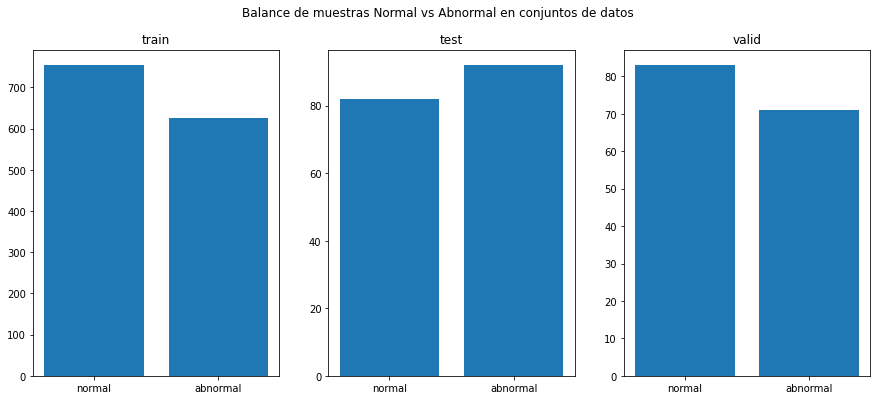

In [9]:
f, axarr = plt.subplots(1,3, figsize=(15,6))

classes = ['normal', 'abnormal']
counts = [normal.shape[0], abnormal.shape[0]]
axarr[0].bar(classes, counts)
axarr[0].set_title('train')

normal = test[np.where(test[:, 1] == 'normal')]
abnormal = test[np.where(test[:, 1] == 'abnormal')]
counts = [normal.shape[0], abnormal.shape[0]]
axarr[1].bar(classes, counts)
axarr[1].set_title('test')

normal = valid[np.where(valid[:, 1] == 'normal')]
abnormal = valid[np.where(valid[:, 1] == 'abnormal')]
counts = [normal.shape[0], abnormal.shape[0]]
axarr[2].bar(classes, counts)
axarr[2].set_title('valid')

plt.suptitle('Balance de muestras Normal vs Abnormal en conjuntos de datos')
plt.show()

# Sección 2. Entrenamiento de una red neuronal sobre una única partición (4 puntos)

Ahora volvemos al artículo y aplicaremos el procesado de datos. Buscar dentro del fichero *data_processing_functions.py* la función que se encarga de llevar a cabo todo el procesado de datos y llamarla desde aquí

This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. Normalization is included as part of the model.

In [10]:
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import timeit
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad


En la siguiente sección cargaremos todos los datasets disponibles en el árbol de directorios de la carpeta 'Fold0'. Estos serán utilizados en todos los modelos.

In [117]:
IMG_SIZE = 224
CLASS_NAMES = ["abnormal", "normal"]
data_dir = os.path.join('Fold0', 'train')
batch_size=32
train_ds = image_dataset_from_directory(
  data_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  label_mode='binary',
  class_names=CLASS_NAMES,
  shuffle=True)

data_dir = os.path.join('Fold0', 'test')
batch_size=32
test_ds = image_dataset_from_directory(
  data_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  label_mode='binary',
  class_names=CLASS_NAMES,  
  shuffle=False)

data_dir = os.path.join('Fold0', 'valid')
batch_size=32
valid_ds = image_dataset_from_directory(
  data_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  label_mode='binary',
  class_names=CLASS_NAMES,  
  shuffle=True)

Found 1379 files belonging to 2 classes.
Found 174 files belonging to 2 classes.
Found 154 files belonging to 2 classes.


In [11]:
def build_model():

    # En caso de querer preprocesar las imagenes, hacer algo parecido a lo comentado.
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    #model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    model = EfficientNetB0(include_top=False, weights="imagenet")
    inputs = model.input
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    # Fully connected layer with 1 class for binary classification
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
 
    model = keras.Model(inputs, outputs, name="EfficientNet")
    return model

In [89]:
model = build_model()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_56 (Rescaling)       (None, None, None,   0           ['input_57[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_56 (Normalizatio  (None, None, None,   7          ['rescaling_56[0][0]']           
 n)                             3)                                                     

In [14]:
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2e2b21c150> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f2e2a1e3e90> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7f2e2a3a8710> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2e2999f910> False
<keras.layers.convolutional.Conv2D object at 0x7f2e29926410> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2e2059f910> False
<keras.layers.core.activation.Activation object at 0x7f2e2059ffd0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f2e204f7690> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2e2056fa10> False
<keras.layers.core.activation.Activation object at 0x7f2e2052a990> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2e20525ed0> False
<keras.layers.core.reshape.Reshape object at 0x7f2e204bc750> False
<keras.layers.convolutional.Conv2D object at 0x7

In [111]:
# Compile
model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy()]
)  
# Entrenar el modelo
t0 = timeit.default_timer()
mfit = model.fit(train_ds, epochs=20, batch_size=128, validation_data=valid_ds)
training_time_ann = timeit.default_timer() - t0

Epoch 1/20
44/44 [==============================] - 11s 117ms/step - loss: 1.0621 - binary_accuracy: 0.5105 - val_loss: 0.4241 - val_binary_accuracy: 0.8377
Epoch 2/20
44/44 [==============================] - 4s 85ms/step - loss: 0.9723 - binary_accuracy: 0.4830 - val_loss: 0.4496 - val_binary_accuracy: 0.8117
Epoch 3/20
44/44 [==============================] - 4s 86ms/step - loss: 0.9354 - binary_accuracy: 0.5149 - val_loss: 0.4555 - val_binary_accuracy: 0.8052
Epoch 4/20
44/44 [==============================] - 4s 86ms/step - loss: 0.9115 - binary_accuracy: 0.5083 - val_loss: 0.4606 - val_binary_accuracy: 0.8052
Epoch 5/20
44/44 [==============================] - 4s 86ms/step - loss: 0.8860 - binary_accuracy: 0.5192 - val_loss: 0.4562 - val_binary_accuracy: 0.8052
Epoch 6/20
44/44 [==============================] - 4s 86ms/step - loss: 0.8432 - binary_accuracy: 0.5294 - val_loss: 0.4682 - val_binary_accuracy: 0.8247
Epoch 7/20
44/44 [==============================] - 4s 86ms/step - l

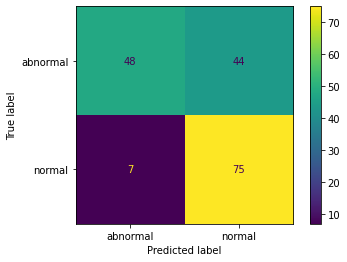

In [113]:
from tensorflow import concat, argmax
def predict_and_plot_confussion_matrix(model, test_ds):
  y_pred = model.predict(test_ds)
  pred_categories = y_pred.round()
  true_categories = concat([y for x, y in test_ds], axis=0)

  fig, ax = plt.subplots()
  cm = confusion_matrix(true_categories, pred_categories)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=["abnormal", "normal"])
  disp.plot(ax=ax)
  plt.show()

predict_and_plot_confussion_matrix(model, test_ds)

In [51]:
#Function to compute several models changing Optimizers and learning rate
def compute(model, train_ds, valid_ds):
  rates = [0.001, 0.01, 0.1]
  optimizers = []
  result = []
  for r in range(len(rates)):
    optimizers.append([SGD(learning_rate=rates[r]), "SGD", rates[r]])
    optimizers.append([Adadelta(learning_rate=rates[r]), "Adadelta", rates[r]])
    optimizers.append([Adagrad(learning_rate=rates[r]), "Adagrad", rates[r]])
    optimizers.append([Adam(learning_rate=rates[r]), "Adam", rates[r]])
 
  for i in range(len(optimizers)):
    optimizer = optimizers[i]
    # Not sure if this helps reseting the model
    model = build_model()
    model.compile(
        optimizer=optimizer[0], 
        loss=keras.losses.BinaryCrossentropy(from_logits=False), 
        metrics=[keras.metrics.BinaryAccuracy()]
    )    
    t0 = timeit.default_timer()
    history = model.fit(train_ds, epochs=20, batch_size=64, verbose=1,
                        validation_data=valid_ds)
    training_time = timeit.default_timer() - t0
    avg_accuracy = np.mean(history.history['val_binary_accuracy'])
    result.append([optimizer[1], optimizer[2], training_time, avg_accuracy])
  return result

In [52]:
#Compute models
c = compute(model, train_ds, valid_ds)

Epoch 1/20
44/44 [==============================] - 12s 114ms/step - loss: 0.7439 - binary_accuracy: 0.6106 - val_loss: 0.6225 - val_binary_accuracy: 0.6688
Epoch 2/20
44/44 [==============================] - 4s 85ms/step - loss: 0.6582 - binary_accuracy: 0.6584 - val_loss: 0.5967 - val_binary_accuracy: 0.7078
Epoch 3/20
44/44 [==============================] - 4s 86ms/step - loss: 0.6271 - binary_accuracy: 0.6730 - val_loss: 0.5700 - val_binary_accuracy: 0.7273
Epoch 4/20
44/44 [==============================] - 4s 86ms/step - loss: 0.5710 - binary_accuracy: 0.7085 - val_loss: 0.5480 - val_binary_accuracy: 0.7273
Epoch 5/20
44/44 [==============================] - 4s 86ms/step - loss: 0.5492 - binary_accuracy: 0.7259 - val_loss: 0.5290 - val_binary_accuracy: 0.7662
Epoch 6/20
44/44 [==============================] - 4s 85ms/step - loss: 0.5359 - binary_accuracy: 0.7382 - val_loss: 0.5138 - val_binary_accuracy: 0.7792
Epoch 7/20
44/44 [==============================] - 4s 85ms/step - l

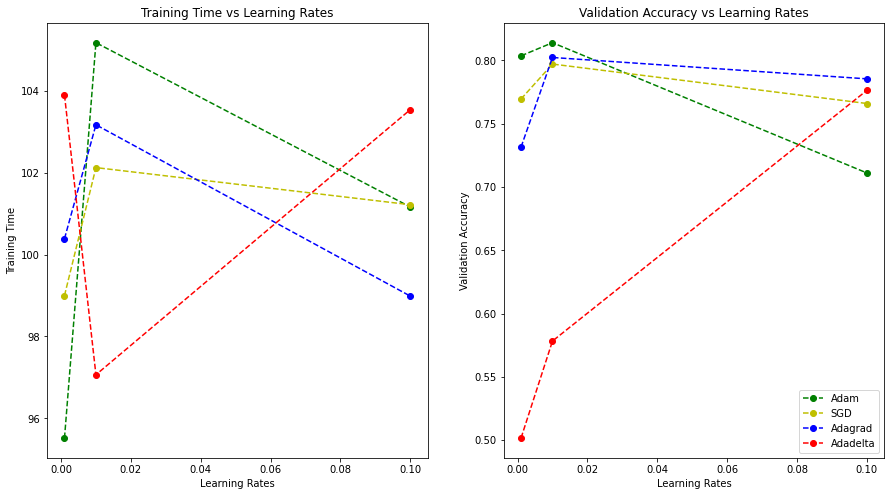

In [58]:
#Plots

# distribuir el resultado en variables más legibles
opts = []
times = []
rates = []
acc = []
for i in range(len(c)):
  m = c[i]
  opts.append(m[0])
  rates.append(m[1])
  times.append(m[2]) 
  acc.append(m[3])

# Variables para las coordenadas de las lineas
adam_rates = []
adam_accuracy = []
adam_times = []
sgd_rates = []
sgd_accuracy = []
sgd_times = []
adagrad_rates = []
adagrad_accuracy = []
adagrad_times = []
adadelta_rates = []
adadelta_accuracy = []
adadelta_times = []

# Transformacion de variables
for i in range(len(times)):
  if opts[i] == 'Adam':
    adam_rates.append(rates[i])
    adam_times.append(times[i])
    adam_accuracy.append(acc[i])
  elif opts[i] == 'SGD':
    sgd_rates.append(rates[i])
    sgd_times.append(times[i])
    sgd_accuracy.append(acc[i])
  elif opts[i] == 'Adagrad':
    adagrad_rates.append(rates[i])
    adagrad_times.append(times[i])
    adagrad_accuracy.append(acc[i])
  elif opts[i] == 'Adadelta':
    adadelta_rates.append(rates[i])
    adadelta_times.append(times[i]) 
    adadelta_accuracy.append(acc[i])

fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(adam_rates, adam_times, linestyle='--', marker='o', color='g', label='Adam')
ax[0].plot(sgd_rates, sgd_times, linestyle='--', marker='o', color='y', label='SGD')
ax[0].plot(adagrad_rates, adagrad_times, linestyle='--', marker='o', color='b', label='Adagrad')
ax[0].plot(adadelta_rates, adadelta_times, linestyle='--', marker='o', color='r', label='Adadelta')
ax[0].set_title('Training Time vs Learning Rates')
ax[0].set_xlabel('Learning Rates')
ax[0].set_ylabel('Training Time')

ax[1].plot(adam_rates, adam_accuracy, linestyle='--', marker='o', color='g', label='Adam')
ax[1].plot(sgd_rates, sgd_accuracy, linestyle='--', marker='o', color='y', label='SGD')
ax[1].plot(adagrad_rates, adagrad_accuracy, linestyle='--', marker='o', color='b', label='Adagrad')
ax[1].plot(adadelta_rates, adadelta_accuracy, linestyle='--', marker='o', color='r', label='Adadelta')
ax[1].set_title('Validation Accuracy vs Learning Rates')
ax[1].set_xlabel('Learning Rates')
ax[1].set_ylabel('Validation Accuracy')
plt.legend()
plt.show()

De los gráficos anteriores, utilizaremos el optimizador SGD con un learning rate de 0.05 dado que, junto con Adagrad, presenta los mejores resultados y tiene un menor tiempo de entrenamiento. Ahora, buscamos número óptimo de épocas con el optimizador seleccionado.

In [59]:
# Plot del training loss y el accuracy
def plot_loss_accuracy(n_epochs, mfit):
  loss = mfit.history['loss']
  val_loss = mfit.history['val_loss']

  accuracy = mfit.history['binary_accuracy']
  val_accuracy = mfit.history['val_binary_accuracy']

  epochs = range(0,n_epochs)
  plt.subplots(figsize=(15,10))
  plt.plot(epochs, loss, 'g', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')

  plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')

  plt.title('Model Loss and Accuracy')
  plt.xticks(epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Total')
  plt.legend()
  plt.show()

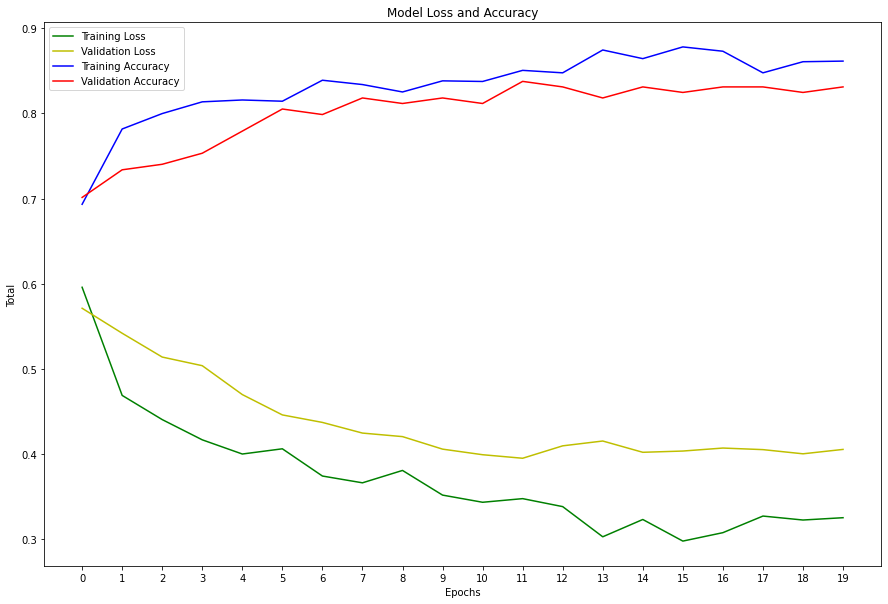

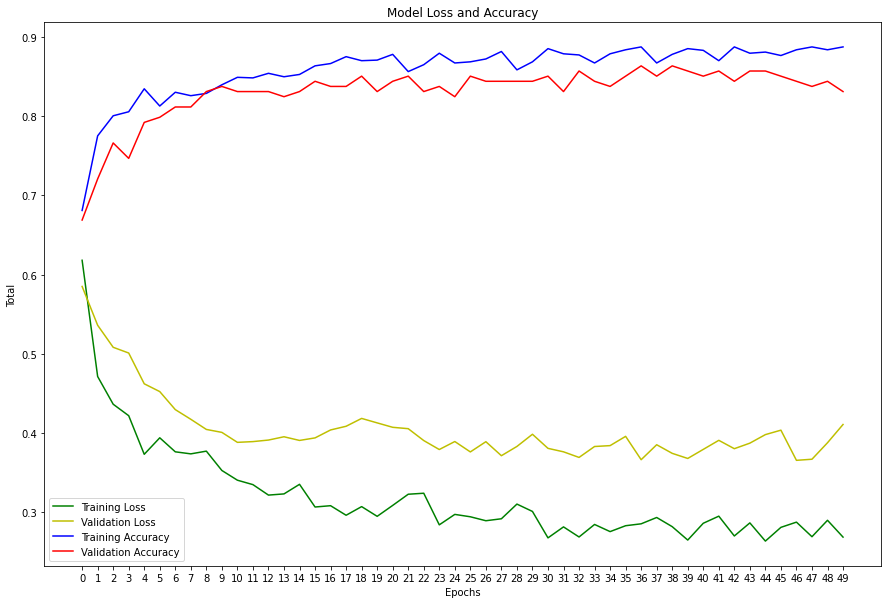

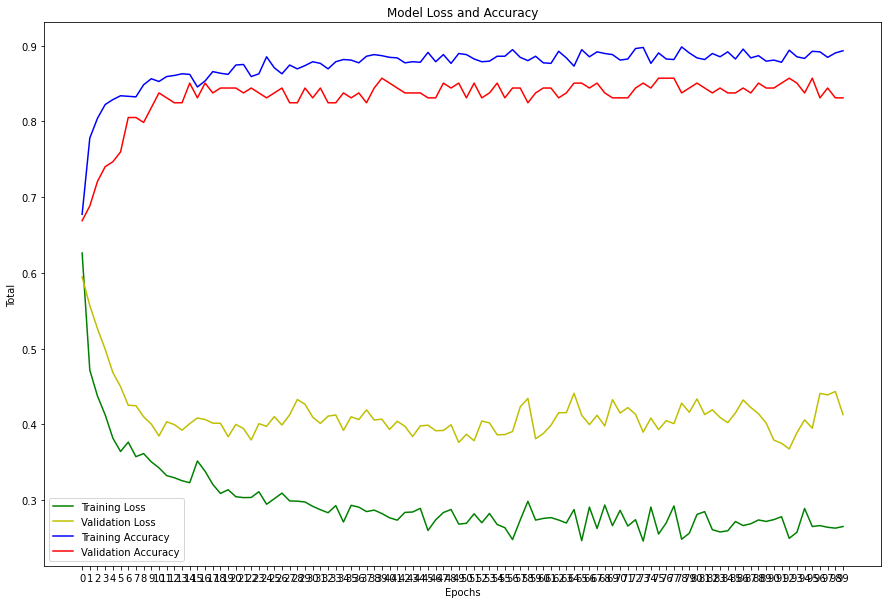

In [60]:
# As result of previous trainings
LEARNING_RATE = 0.001

#Function to compute several models changing epochs
def compute_epochs(train_ds, valid_ds):
  epochs = [20, 50, 100]
 
  for i in range(len(epochs)):
    # Not sure if this helps reseting the model
    model = build_model()
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE), 
        loss=keras.losses.BinaryCrossentropy(from_logits=False), 
        metrics=[keras.metrics.BinaryAccuracy()]
    )      
    t0 = timeit.default_timer()
    history = model.fit(train_ds, epochs=epochs[i], batch_size=64, verbose=0,
                        validation_data=valid_ds)
    training_time = timeit.default_timer() - t0
    plot_loss_accuracy(epochs[i], history)
    avg_accuracy = np.mean(history.history['val_binary_accuracy'])

compute_epochs(train_ds, valid_ds)

En este momento tenemos claros las épocos y los hyperparámetros a utilizar para el modelo 1. Lo preparamos de cero y generamos sus resultados.

Epoch 1/50
44/44 [==============================] - 11s 115ms/step - loss: 0.6664 - binary_accuracy: 0.6519 - val_loss: 0.6200 - val_binary_accuracy: 0.6039
Epoch 2/50
44/44 [==============================] - 4s 87ms/step - loss: 0.4894 - binary_accuracy: 0.7679 - val_loss: 0.5728 - val_binary_accuracy: 0.6753
Epoch 3/50
44/44 [==============================] - 4s 86ms/step - loss: 0.4451 - binary_accuracy: 0.7897 - val_loss: 0.5420 - val_binary_accuracy: 0.7078
Epoch 4/50
44/44 [==============================] - 4s 87ms/step - loss: 0.4062 - binary_accuracy: 0.8144 - val_loss: 0.5059 - val_binary_accuracy: 0.7468
Epoch 5/50
44/44 [==============================] - 4s 86ms/step - loss: 0.3996 - binary_accuracy: 0.8122 - val_loss: 0.4983 - val_binary_accuracy: 0.7597
Epoch 6/50
44/44 [==============================] - 4s 87ms/step - loss: 0.3800 - binary_accuracy: 0.8274 - val_loss: 0.4763 - val_binary_accuracy: 0.7857
Epoch 7/50
44/44 [==============================] - 4s 86ms/step - l

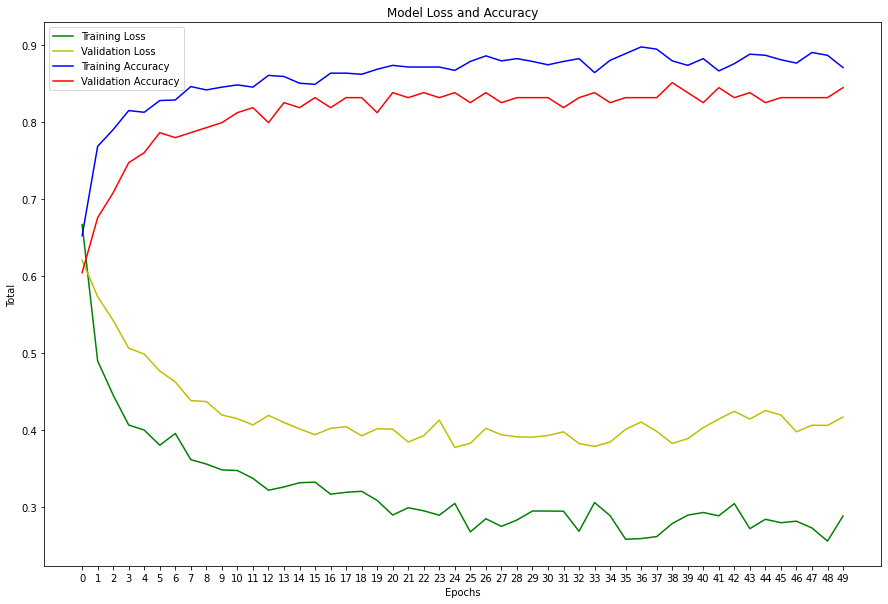

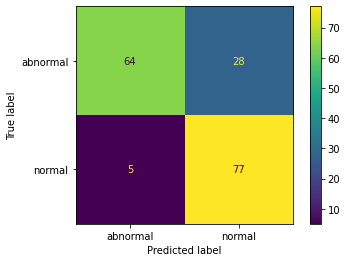

In [118]:
# As result of previous trainings
EPOCHS = 50

model_top_layer = build_model()
# Compile
model_top_layer.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Entrenar el modelo
t0 = timeit.default_timer()
history = model_top_layer.fit(train_ds, epochs=EPOCHS, batch_size=32, validation_data=valid_ds, verbose=1)
training_time_ann = timeit.default_timer() - t0
plot_loss_accuracy(EPOCHS, history)

predict_and_plot_confussion_matrix(model_top_layer, test_ds)

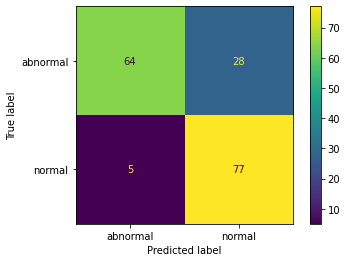

In [119]:
predict_and_plot_confussion_matrix(model_top_layer, test_ds)

In [62]:
def unfreeze_layers(model, nlayers):

  model_layers = len(model.layers)
  if nlayers >= model_layers:
    model.trainable = True
  else:
    unfreeze(model, nlayers)

  return model

def unfreeze(model, nlayers):

  model_layers = len(model.layers)
  for i in range(1,nlayers +1):
    layer = model.get_layer(index=(model_layers - i))
    if isinstance(layer,layers.BatchNormalization):
      layer.trainable = False
    else:
      layer.trainable = True
  return model


model = build_model()
model = unfreeze_layers(model, 20)
model.summary()



Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_54 (Rescaling)       (None, None, None,   0           ['input_55[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_54 (Normalizatio  (None, None, None,   7          ['rescaling_54[0][0]']           
 n)                             3)                                                     

In [63]:
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2c81a858d0> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f2d921a7690> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7f2d6ce285d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2c81acb6d0> False
<keras.layers.convolutional.Conv2D object at 0x7f2c81abafd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2c81c68bd0> False
<keras.layers.core.activation.Activation object at 0x7f2d6d5c2a10> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f2d0a549d90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2d922595d0> False
<keras.layers.core.activation.Activation object at 0x7f2d6ccc9b10> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2c81afdd10> False
<keras.layers.core.reshape.Reshape object at 0x7f2d0a55e410> False
<keras.layers.convolutional.Conv2D object at 0x7

Epoch 1/50
44/44 [==============================] - 11s 122ms/step - loss: 0.4860 - binary_accuracy: 0.7534 - val_loss: 0.6910 - val_binary_accuracy: 0.7403
Epoch 2/50
44/44 [==============================] - 4s 92ms/step - loss: 0.3894 - binary_accuracy: 0.8194 - val_loss: 0.3151 - val_binary_accuracy: 0.8442
Epoch 3/50
44/44 [==============================] - 4s 91ms/step - loss: 0.2972 - binary_accuracy: 0.8774 - val_loss: 0.3126 - val_binary_accuracy: 0.8442
Epoch 4/50
44/44 [==============================] - 4s 90ms/step - loss: 0.2675 - binary_accuracy: 0.8869 - val_loss: 0.3888 - val_binary_accuracy: 0.8571
Epoch 5/50
44/44 [==============================] - 4s 91ms/step - loss: 0.2145 - binary_accuracy: 0.9101 - val_loss: 0.4805 - val_binary_accuracy: 0.8247
Epoch 6/50
44/44 [==============================] - 4s 91ms/step - loss: 0.2397 - binary_accuracy: 0.9007 - val_loss: 0.3812 - val_binary_accuracy: 0.8506
Epoch 7/50
44/44 [==============================] - 4s 91ms/step - l

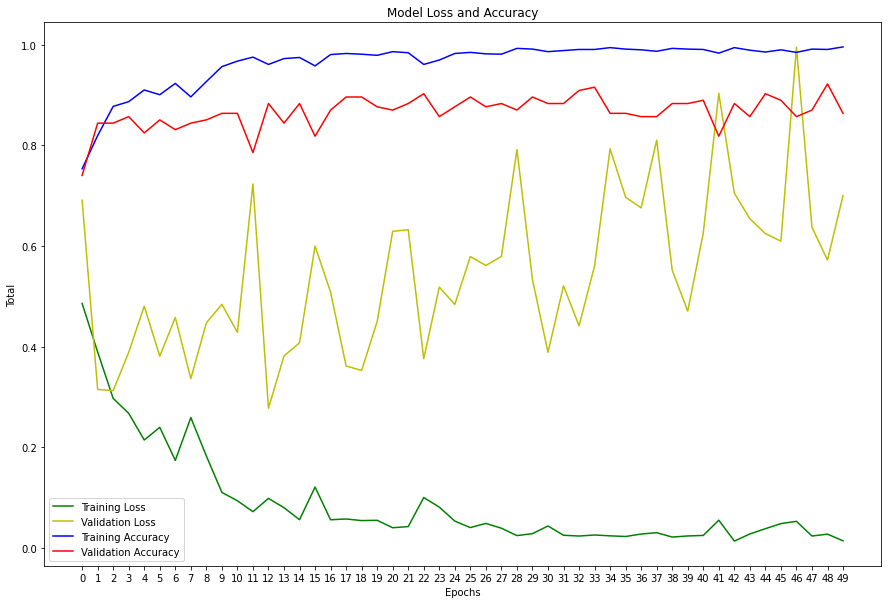

In [64]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Entrenar el modelo
t0 = timeit.default_timer()
history = model.fit(train_ds, epochs=50, batch_size=32, validation_data=valid_ds, verbose=1)
training_time_ann = timeit.default_timer() - t0
plot_loss_accuracy(50, history)

Epoch 1/50
44/44 [==============================] - 24s 356ms/step - loss: 0.5942 - binary_accuracy: 0.7875 - val_loss: 0.7143 - val_binary_accuracy: 0.5519
Epoch 2/50
44/44 [==============================] - 15s 329ms/step - loss: 0.2977 - binary_accuracy: 0.8782 - val_loss: 0.7929 - val_binary_accuracy: 0.5714
Epoch 3/50
44/44 [==============================] - 15s 329ms/step - loss: 0.2428 - binary_accuracy: 0.9007 - val_loss: 1.0772 - val_binary_accuracy: 0.4935
Epoch 4/50
44/44 [==============================] - 15s 322ms/step - loss: 0.1827 - binary_accuracy: 0.9304 - val_loss: 1.2615 - val_binary_accuracy: 0.5455
Epoch 5/50
44/44 [==============================] - 15s 322ms/step - loss: 0.1922 - binary_accuracy: 0.9282 - val_loss: 0.7944 - val_binary_accuracy: 0.5844
Epoch 6/50
44/44 [==============================] - 15s 323ms/step - loss: 0.1220 - binary_accuracy: 0.9500 - val_loss: 0.7728 - val_binary_accuracy: 0.6429
Epoch 7/50
44/44 [==============================] - 15s 32

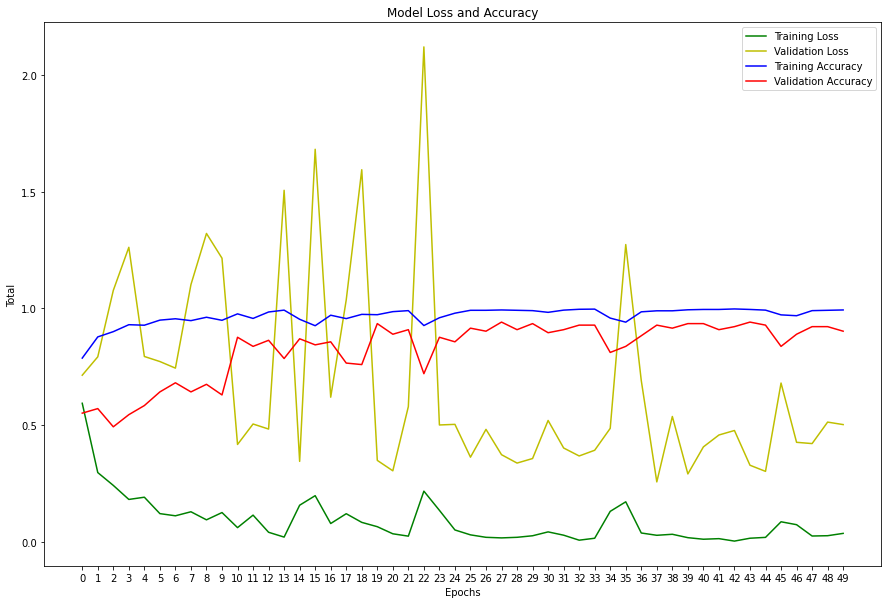

In [65]:
model = build_model()
model.trainable = True

# Compile
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Entrenar el modelo
t0 = timeit.default_timer()
history = model.fit(train_ds, epochs=EPOCHS, batch_size=32, validation_data=valid_ds, verbose=1)
training_time_ann = timeit.default_timer() - t0
plot_loss_accuracy(EPOCHS, history)

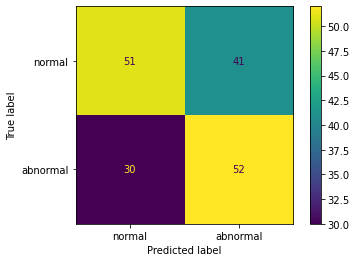

In [88]:


predict_and_plot_confussion_matrix(model, test_ds)